# Exponential Mechanism

We introduce the Exponential mechanism as in [The Algorithmic Foundations of Differential Privacy](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf). Let $\mathcal X$ be the set of possible rows in a database so that we can represent a particular database by a histogram $x\in\mathbb N^{|\mathcal X|}$. Given an arbitrary response space $\mathcal R$ and a utility function

$$
u: \mathbb N^{|\mathcal X|}\times \mathcal R \rightarrow \mathbb R\,,
$$

we define the exponential mechanism as the collection of conditional probabilities given by

$$
P(r|x; u, \alpha) = \frac{e^{\alpha u(x,r) }}{\sum_{r'\in\mathcal R} e^{\alpha u(x,r')}}\,.
$$

In the case of uncountable $\mathcal R$, the sum in the denominator should be replaced with an integral and the expression above gives a probability density.

The exponential mechanism is an $\epsilon$-differentially private randomization algorithm with $\epsilon = 2\alpha\Delta u$ and

$$
\Delta u = \underset{r\in\mathcal R}{\rm max}\underset{||x-y||_1 \le 1}{\rm max} |u(x,r) - u(y,r)|\,.
$$

The utility function can be thought of as a generalization of a numeric query. In fact, one can show that this mechanism reduces to simpler ones for particular types of functions $u$. In order to illustrate this, we show how this works in two well-known examples.

#### Randomized response

Consider the case in which $\mathcal R = \{0, 1\}$ and $\mathcal X = \{\text{truly innocent}, \text{truly guilty}\}$ with a utility function such that 

$$
u(0, 0) = \beta_0\qquad u(1, 0) = \beta_1\\ u(0, 1) = \gamma_0 \qquad u(1, 1) = \gamma_1
$$

where $\beta_0, \beta_1, \gamma_0, \gamma_1$ are real constants. The exponential mechanism reduces in this case to the simplest randomized response algorithm.


#### Laplace Mechanism

Consider the case in which $\mathcal R = \mathbb R$ and the ultility function is given by $u(x, r) = -|f(x) - r|$ with

$$
f: \mathbb N^{|\mathcal X|} \rightarrow \mathbb R\,.
$$

This is, by definition, the Laplace mechanism with $b = \alpha^{-1}$. Notice that, for this particular utility function, the quantity $\Delta u = \Delta f$, where $\Delta f$ is the sensitivity of $f$.




## Example: Pricing

The input dataset $x$ is a set of bids for the purchase of an abundant supply of a product. The problem is to identify the best price $r \in \mathcal{R} = [r_{min}, r_{max}]$ such as to maximize the revenue, without revealing the bids. In this case the revenue is our utility function $u$, defined as

$$
u(x, r) = r |S_r|
$$

with 

$$
S_r = \{i: x_i\ge r\}\,
$$

the set of people that are willing to buy at a price $r$.

In general, it is not possible to compute $\Delta u$ analytically and one must resort to statistical estimations of "typical" values of $\Delta u$. This is also the case when $\Delta u$ is not bounded. In our particular case, we can compute the sensitivity with respect to the utility, which is given by

$$
\Delta u = r_{max}.
$$

The complication in this case arises from the fact that the output price may not be directly perturbed. For example [Dwork], suppose there are four bidders: A, F, I, K, where where A, F, I each bid 1.00&euro; and K bids 3.01&euro;, so $x = \{1, 1, 1, 3.01\}$.  Fixing the price to 3.01&euro; the revenue is $u =$ 3.01&euro;, at 3.00&euro; we have $u =$3.00&euro;, at 1.00&euro; we have $u =$4.00&euro;. However, if we fix the price at 3.02&euro; the revenue is zero! The revenue plot for this specific demand defined by $x$ is shown below. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

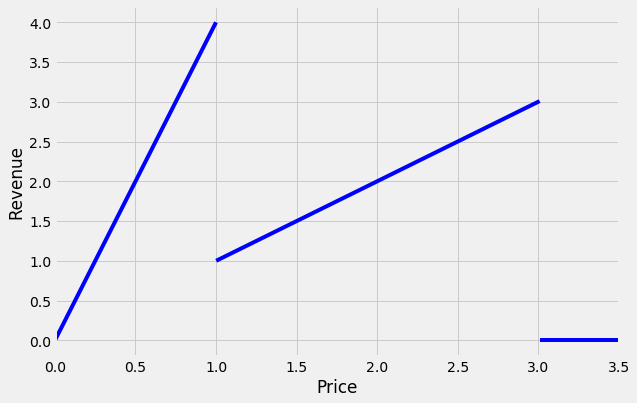

In [2]:
x = [1.00, 1.00, 1.00, 3.01] # Input dataset: the true bids

# Construct the revenue plot:
r_min, r_max = 0, 3.5        # Set extreme values
r_range = np.arange(r_min, r_max, 0.001)
def revenue(x, r_range):
    output = np.zeros(len(r_range))
    for i in range(len(r_range)): 
        output[i] = r_range[i] * sum(np.greater_equal(x, r_range[i]))
    return(output)

u = revenue(x, r_range)

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(9, 6))

x_intervals = np.sort(np.unique(np.append(x, [r_min, r_max])))
for i_interval in range(len(x_intervals) - 1):
    indices_interval = [all(union) for union in zip(
        r_range > x_intervals[i_interval], r_range <= x_intervals[i_interval + 1])]
    ax.plot(r_range[indices_interval], u[indices_interval], color = "blue")

ax.set_xlim([r_min, r_max])
ax.set_xlabel('Price')
ax.set_ylabel('Revenue')

plt.show()

The Exponential mechanism is defined with respect the utility function $u : \mathbb N^{|\mathcal{X}|} \times \mathcal{R} \rightarrow \mathbb{R}$, which maps database/output *pairs* to utility scores. For a fixed database $x$, the exponential mechanism outputs each possible $r \in \mathcal{R}$ with probability proportional to $\exp\left(\frac{\epsilon u\left(x, r\right)}{2\Delta u}\right)$. The resulting probability distribution is shown below. 

In [3]:
def norm_pdf(x, r_min, r_max, epsilon):
    x_intervals = np.sort(np.unique(np.append(x, [r_min, r_max])))
    area = 0
    for i in range(len(x_intervals) - 1):
        S = epsilon/(2*r_max) * sum(np.greater(x, x_intervals[i]))
        if S > 0:
            area_int = 1/S * (np.exp(S * x_intervals[i + 1]) - np.exp(S * x_intervals[i]))
        elif S == 0:
            area_int = x_intervals[i + 1] - x_intervals[i]
        area = area + area_int
    return area

def PDF(r_range, x, r_min, r_max, epsilon, norm):
    """Compute a valid PDF"""
    u = revenue(x, r_range)
    u_prob_norm = np.exp(epsilon * u / (2 * r_max)) / norm
    return(u_prob_norm)

def CDF(r_range, x, r_min, r_max, epsilon, norm):
    output = np.zeros(len(r_range))
    for i in range(len(r_range)):
        r = r_range[i]
        x_intervals = np.sort(np.unique(np.append(x, [r_min, r, r_max])))
        x_intervals = x_intervals[x_intervals <= r]
        for j in range(len(x_intervals) - 1):
            S = epsilon/(2*r_max) * sum(np.greater(x, x_intervals[j]))
            if S > 0:
                area_int = 1/S * (np.exp(S * x_intervals[j + 1]) - np.exp(S * x_intervals[j]))
            elif S == 0:
                area_int = x_intervals[j + 1] - x_intervals[j]
            output[i] = output[i] + area_int
        output[i] = output[i] / norm
    return output

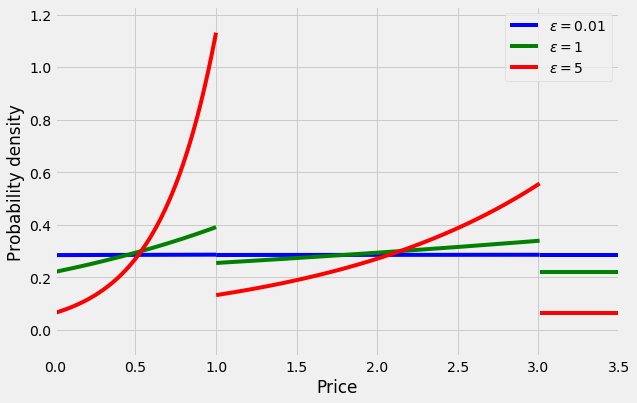

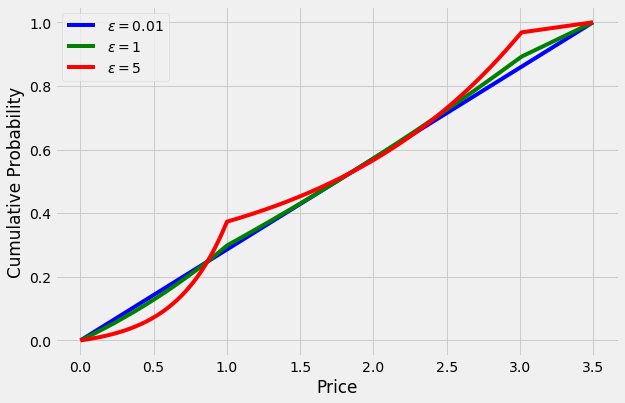

In [4]:
epsilon_range = [0.01, 1, 5]

fig, ax = plt.subplots(figsize=(9,6))
fig2, ax2 = plt.subplots(figsize=(9,6))

color_list = ["b", "g", "r", "c", "m"]

x_intervals = np.sort(np.unique(np.append(x, [r_max, r_min])))
for i_epsilon in range(len(epsilon_range)):
    norm = norm_pdf(x, r_min, r_max, epsilon_range[i_epsilon])
    u_prob_norm = PDF(r_range, x, r_min, r_max, epsilon_range[i_epsilon], norm)
    P_x = CDF(r_range, x, r_min, r_max, epsilon_range[i_epsilon], norm)
    ax2.plot(r_range, P_x, color = color_list[i_epsilon])
    for i_interval in range(len(x_intervals) - 1):
        indices_interval = [all(union) for union in zip(
            r_range > x_intervals[i_interval], r_range <= x_intervals[i_interval + 1])]
        ax.plot(r_range[indices_interval], 
                u_prob_norm[indices_interval], 
                color = color_list[i_epsilon], 
                label = '$\epsilon = $' + str(epsilon_range[i_epsilon]))

handles, labels = ax.get_legend_handles_labels()  
handles = handles[0:len(handles):(len(x)-1)] # Modify legend labels and handles
labels = labels[0:len(labels):(len(x)-1)]
ax.set_xlim([r_min, r_max])
ax.set_ylim([-0.1, max(u_prob_norm) + 0.1])
ax.set_xlabel('Price')
ax.set_ylabel('Probability density')
ax.legend(handles, labels)

ax2.set_xlabel('Price')
ax2.set_ylabel('Cumulative Probability')
ax2.legend(handles, labels)

plt.show()

The privacy mechanism samples the price $r \in \mathcal{R}$ from the above probability distribution. 
The exponential mechanism exhibits typically strong utility guarantees, because it decreases outcomes exponentially quickly as their utility score falls off.

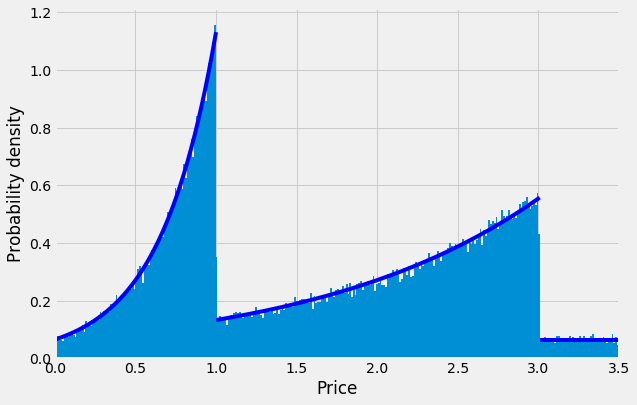

In [8]:
from random import sample 

epsilon = 5
norm = norm_pdf(x, r_min, r_max, epsilon)
u_prob_norm = PDF(r_range, x, r_min, r_max, epsilon, norm)

def CDF_inv(z_range, x, r_min, r_max, epsilon, norm):
    x_intervals = np.sort(np.unique(np.append(x, [r_min])))
    z_intervals = CDF(x_intervals, x, r_min, r_max, epsilon, norm)
    r_out_range = np.zeros(len(z_range))
    for i in range(len(z_range)):
        z = z_range[i]
        z_min = max(z_intervals[z_intervals <= z])
        x_min = max(x_intervals[z_intervals <= z])
        S = epsilon/(2*r_max) * sum(np.greater(x, x_min))
        if S > 0:
            r = 1/S * np.log(S*norm*(z-z_min) + np.exp(S*x_min))
        else:
            r = x_min + norm * (z - z_min)
        r_out_range[i] = r
    return r_out_range

z_range = np.random.uniform(size = 100000)
price_sample = CDF_inv(z_range, x, r_min, r_max, epsilon, norm)

fig, ax = plt.subplots(figsize=(9,6))
# Verify the sampling resembles price probability distribution: 
x_intervals = np.sort(np.unique(np.append(x, [r_max, r_min])))
for i_interval in range(len(x_intervals) - 1):
    indices_interval = [all(union) for union in zip(
        r_range > x_intervals[i_interval], r_range <= x_intervals[i_interval + 1])]
    ax.plot(r_range[indices_interval], u_prob_norm[indices_interval], color = "blue")
    
plt.hist(price_sample, bins = int(round(np.sqrt(len(price_sample)))), density = True)
ax.set_xlim([r_min, r_max])
ax.set_xlabel('Price')
ax.set_ylabel('Probability density')
plt.show()

The trade-off between accuracy and privacy can be assessed by computing the mean revenue loss, which is defined as

$${\rm loss}= |u_{OPT}(x) - u(x,r_{sample})|$$ 

where $u_{OPT}(x)$ is the highest possible revenue for a fixed database $x$, and $u(x,r_{sample})$ is the revenue at the sampled price $r_{sample}$.

This is a measure of the loss in utility that we get when using the exponential mechanism compared to the case without privacy at all. The plot below shows that as $\epsilon$ increases (i.e. privacy decreases) the revenue loss goes to zero. 

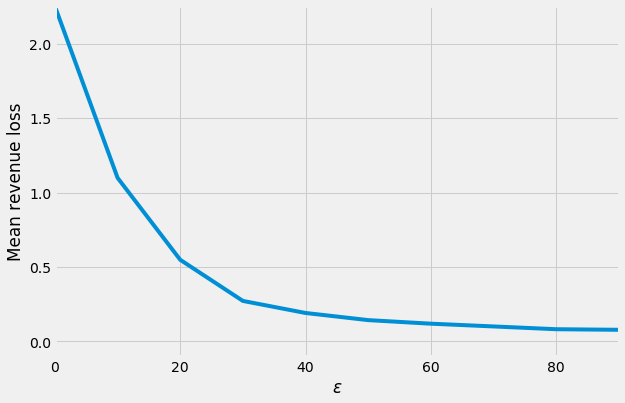

In [6]:
epsilon_range = np.arange(0.001, 100, 10)
optimum_price = float(r_range[u == max(u)])
optimum_revenue = revenue(x, [optimum_price])
mean_loss = np.zeros(len(epsilon_range))

for i in range(len(epsilon_range)):
    epsilon = epsilon_range[i]
    norm = norm_pdf(x, r_min, r_max, epsilon)
    u_prob_norm = PDF(r_range, x, r_min, r_max, epsilon, norm)
    P_x = CDF(r_range, x, r_min, r_max, epsilon, norm)
    price_sample = CDF_inv(np.random.uniform(size = 1000), x, r_min, r_max, epsilon, norm)
    mean_loss[i] = np.mean(abs(revenue(x, price_sample) - optimum_revenue))

fig, ax = plt.subplots(figsize=(9,6))
ax.plot(epsilon_range, mean_loss)
ax.set_xlim([0, max(epsilon_range)])
ax.set_ylim([-0.1, max(mean_loss)])
ax.set_xlabel('$\epsilon$')
ax.set_ylabel('Mean revenue loss')

plt.show()